In [272]:
import pandas as pd
# Set max columns to display
pd.set_option('display.max_columns', None)

import numpy as np
from sklearn import preprocessing as pre
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px

In [273]:

df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\3 Feature Selection\contData_all_Avg - 1o2.csv')
df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\3 Feature Selection\contData_all_Avg - 2o2.csv')
# Concatenate (union) the dataframes
df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

print(df_All.head())

    425 %Al    Butanol   Decanol    Ethanol   Hexanol   Octanol   AYC55580  \
0  6.319560  30.366200  1.030260  88.289900  1.365840  1.492120  18.297300   
1  6.319915  30.678500  1.063260  89.685450  1.397135  1.548230  18.040650   
2  6.328340  32.399333  1.647950  88.677200  1.994413  2.454430  16.637633   
3  6.336760  32.845950  1.928805  87.080875  2.288335  2.897523  15.779400   
4  6.337460  33.387025  2.352595  84.489175  2.734682  3.571185  15.199680   

    DI55102   DI55152   DI55580      FC42428      FC52018    FC55003  \
0  0.963347  0.924879  1.017340  40773.90000  42583.40000  5622.8300   
1  0.965043  0.924515  1.014885  40816.90000  44547.30000  5308.8850   
2  0.968107  0.929955  1.015593  41080.96667  45105.73333  5489.7400   
3  0.969573  0.932388  1.014703  41606.60000  45413.77500  5709.1825   
4  0.971022  0.934531  1.014094  41722.12000  45547.02000  5653.1640   

       FC55009      FC55102      FC55152   FC55552      FC55555      FC55569  \
0  1770.180000  54

In [274]:

TagDesc = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv")
# df_All = pd.read_csv(r"C:\Users\saust\OneDrive - Sasol\1 Project rC4\Jupyter Notebooks\Report 10-19-23\df_AlConCD554.csv")
#df_All = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\CodeSpace DLs\102423\Project rC4\5 Engineered Features\3 - EF - Feature Selection\df_CDFI.csv")


# FScore = pd.read_csv(r"C:\Users\saust\OneDrive\Desktop\CodeSpace DLs\102423\Project rC4\5 Engineered Features\3 - EF - Feature Selection\FScore_on_Butanol_310.csv")

# df_All = pd.read_csv('/workspaces/codespaces-jupyter/ProjectrC4/df_AlConCD554.csv')

In [275]:
# List of columns to exclude to run XGboost feature selection
exclude_columns = [
       
       # Sample data of the same time introcuces Data leakage
       'Octanol', 'Hexanol', 'Ethanol', 'Decanol',

       # Highly correlated to TC's
       'TI52014', 'TI55013', 'TI55014', 'TI55015', 'TI55016', 'TI55017', 'TI55021', 'TI55023', 'TI40050',
       
       # Niro Functions
       'TC52015', 'FC52018', 'II52554', 'VI52558B',
       
       # .9 to .8 Correlations
       'FC55555',  # First Drop - Highest correlated variable    #Almost 1 with FC55552 - as determined by Ratio controller    
       'PI55560',   # Exlude middle pressure - Include -> PI5500: btm pressure 
       'FYC55553',  # Calculates by other varibales (inherently correlated) - Include -> FC55552 - leading influecner 
       'FC55152', 'FC55102', # Both are deritives of FC55552
       'AYC55580',  # Is calculated - DI55580 measures the process directly
       
       # .7 Correlations
       # FC55552 --> FC42428 = 0.70526 / not comfortable droping either at this time

       # .6 Correlations
       'TC55566',  # Is a Downstream requirement - TC55552 occurs upstream (DC-551 ALKOX  FD PREHEAT)

       # .5 Correlations
       'FC55009' # Receives its SP from TC55553

                   ]

# Create a new DataFrame without the excluded columnsd
df_All = df_All.drop(columns=exclude_columns)

# Check Basic Information:

In [276]:


df_All.info() #to check the data types, non-null counts, and memory usage.
df_All.head() #to examine the first few rows of the dataset.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49239 entries, 0 to 49238
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   425 %Al   49239 non-null  float64
 1   Butanol   49239 non-null  float64
 2   DI55102   49239 non-null  float64
 3   DI55152   49239 non-null  float64
 4   DI55580   49239 non-null  float64
 5   FC42428   49239 non-null  float64
 6   FC55003   49239 non-null  float64
 7   FC55552   49239 non-null  float64
 8   FC55569   49239 non-null  float64
 9   FC55576   49239 non-null  float64
 10  FFC55553  49239 non-null  float64
 11  FFC55555  49239 non-null  float64
 12  LC52572   49239 non-null  float64
 13  LC55553   49239 non-null  float64
 14  LC55555   49239 non-null  float64
 15  LC55557   49239 non-null  float64
 16  LC55568   49239 non-null  float64
 17  LC90366   49239 non-null  float64
 18  LC90368   49239 non-null  float64
 19  PI55004   49239 non-null  float64
 20  PI55020   49239 non-null  fl

,425 %Al,Butanol,DI55102,DI55152,DI55580,FC42428,FC55003,FC55552,FC55569,FC55576,FFC55553,FFC55555,LC52572,LC55553,LC55555,LC55557,LC55568,LC90366,LC90368,PI55004,PI55020,TC55552,TC55553,TC55555
0,6.319560,30.366200,0.963347,0.924879,1.017340,40773.90000,5622.8300,40424.10,6928.310000,329.7610,1.045930,0.752379,66.534100,62.176800,60.362200,65.484000,40.136500,16.706900,49.278800,1.044590,-0.437499,178.773000,235.047000,179.6930
1,6.319915,30.678500,0.965043,0.924515,1.014885,40816.90000,5308.8850,40409.25,6924.645000,322.1770,1.049540,0.751183,66.523200,62.921050,60.446750,66.313950,40.252500,15.449150,49.267500,1.236360,-0.389406,179.011500,213.937500,179.9940
2,6.328340,32.399333,0.968107,0.929955,1.015593,41080.96667,5489.7400,40606.30,6925.813333,324.9680,1.050217,0.761243,66.500500,62.651867,60.350800,66.212233,40.059967,10.931340,48.643200,1.189883,-0.377156,180.276667,205.221667,180.0530
3,6.336760,32.845950,0.969573,0.932388,1.014703,41606.60000,5709.1825,39171.20,6920.290000,331.7720,1.050780,0.766600,66.336525,62.526325,60.118475,65.893675,39.835675,8.674930,48.382975,1.343838,-0.366302,180.993250,198.353500,180.5790
4,6.337460,33.387025,0.971022,0.934531,1.014094,41722.12000,5653.1640,39099.64,6916.018000,336.2358,1.051672,0.770305,65.981980,62.293540,60.150020,66.212620,40.179880,7.325074,48.332800,1.535224,-0.327278,181.511000,195.641600,180.2476


# Summary Statistics:

In [277]:


df_All.describe() #to get summary statistics for numeric columns.


,425 %Al,Butanol,DI55102,DI55152,DI55580,FC42428,FC55003,FC55552,FC55569,FC55576,FFC55553,FFC55555,LC52572,LC55553,LC55555,LC55557,LC55568,LC90366,LC90368,PI55004,PI55020,TC55552,TC55553,TC55555
count,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000,49239.000000
mean,6.128382,8.938060,0.929931,0.941467,0.997996,35927.743355,5961.207018,36376.905162,6597.603766,370.782576,0.993808,0.774193,63.062007,63.507380,57.983777,69.791916,41.094421,47.197146,38.307375,2.224342,-1.479487,168.734200,182.709401,180.979496
std,0.258963,8.759664,0.067055,0.039434,0.049639,4957.199185,755.225407,3911.714945,354.077661,250.999270,0.038780,0.022786,2.379834,6.845503,10.548250,2.972439,1.267912,28.003793,20.202085,1.146045,1.070333,15.133759,27.420831,1.442948
min,5.085695,0.361524,0.794570,0.820011,0.845520,17367.337500,3136.851250,19859.750000,5227.756250,0.000000,0.825233,0.698977,53.960450,42.918213,39.513463,60.445813,32.926262,0.000000,0.118033,0.058151,-4.614894,121.490875,131.866500,178.943750
25%,5.989670,3.710000,0.892381,0.915246,0.966598,33975.381250,5490.615000,35271.768750,6379.216250,190.819625,0.970126,0.759779,61.824531,60.054700,49.511819,67.987944,40.835825,23.552054,23.290450,1.306537,-2.303582,156.098687,163.335125,179.977875
50%,6.131580,5.704607,0.940508,0.937841,0.997425,37702.600000,5977.093750,37932.387500,6573.695000,340.938500,0.991813,0.778917,63.320400,65.205862,60.034613,70.074462,41.255237,49.845937,43.945575,2.008314,-1.486482,172.376000,176.618875,180.061500
75%,6.271303,10.096646,0.980741,0.961515,1.032216,39316.200000,6486.138125,38984.393750,6801.608125,524.029688,1.012375,0.789956,64.904506,68.057325,66.939406,71.955481,41.493594,73.482550,53.481931,2.989508,-0.504678,180.775750,200.880063,181.989125
max,7.170805,55.772500,1.066724,1.062941,1.131526,46225.862500,8724.858750,41922.012500,7982.280000,1133.776250,1.152818,0.849271,71.429825,78.015237,78.551250,79.127337,48.429475,87.901600,81.156950,6.171575,1.184724,201.847250,245.420125,186.049250


# Check for Missing Values:

In [278]:


df_All.isnull().sum() #to check the number of missing values in each column.


425 %Al     0
Butanol     0
DI55102     0
DI55152     0
DI55580     0
FC42428     0
FC55003     0
FC55552     0
FC55569     0
FC55576     0
FFC55553    0
FFC55555    0
LC52572     0
LC55553     0
LC55555     0
LC55557     0
LC55568     0
LC90366     0
LC90368     0
PI55004     0
PI55020     0
TC55552     0
TC55553     0
TC55555     0
dtype: int64

# Correlation Analysis:

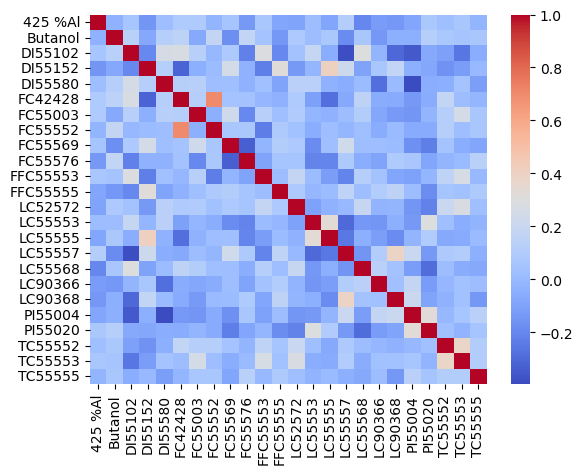

In [279]:
correlation_matrix = df_All.corr(numeric_only = True)

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()
# Calculate and visualize correlations between numeric variables using a correlation matrix or heatmap.
# Identify strong positive/negative correlations.

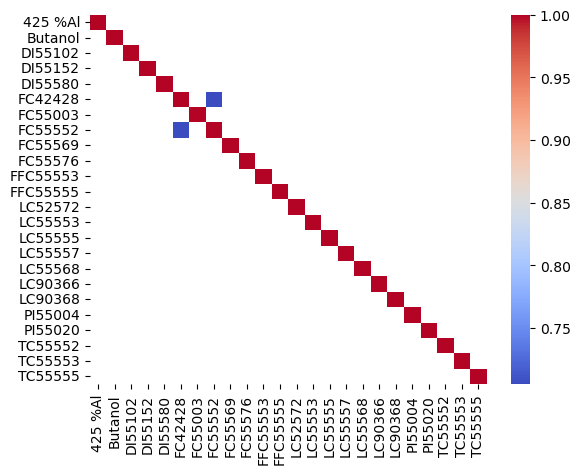

In [280]:
strong_corr = correlation_matrix[abs(correlation_matrix) > 0.5]

sns.heatmap(strong_corr, annot=False, cmap='coolwarm', fmt=".2f")
plt.show()

In [281]:
threshold = 0.5
correlation_matrix = df_All.corr(numeric_only=True)
correlation_matrix = correlation_matrix[abs(correlation_matrix) > threshold].fillna(0)



fig = px.imshow(correlation_matrix, 
                color_continuous_scale='Viridis',
                labels=dict(x="Features", y="Features", color="Correlation"),
                title="Correlation Matrix")

fig.update_xaxes(title_text='Features', side='bottom')
fig.update_layout(width=800, height=800)

fig.show()



In [282]:
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)


In [283]:
# Get indices of upper triangle where correlations are above threshold
indices = np.where((np.abs(correlation_matrix) > threshold) & (upper_triangle))

# Convert these indices to lists
rows, cols = indices[0].tolist(), indices[1].tolist()

# Construct pairs and fetch corresponding values 'DESCRIPTION'


data = []
correlation_id = 1  # Start the unique identifier for each correlation pair

for row, col in zip(rows, cols):
    # Ensure v1 is always lexicographically smaller than v2
    v1, v2 = sorted([correlation_matrix.columns[row], correlation_matrix.columns[col]])
    
    # Skip if this pair has already been processed
    if any(x[1] == v1 and x[2] == v2 for x in data):
        continue

    correlation_value = correlation_matrix.loc[v1, v2]
    
    # Fetch other required values for v1
    # importance1 = FScore[FScore['Feature'] == v1]['Importance'].values[0] if not FScore[FScore['Feature'] == v1].empty else "N/A"
    DESCRIPTION1 = TagDesc[TagDesc['ID'] == v1]['DESCRIPTION'].values[0] if not TagDesc[TagDesc['ID'] == v1].empty else "####### UPDATE DESCRIPTION"
    
    # Fetch other required values for v2
    # importance2 = FScore[FScore['Feature'] == v2]['Importance'].values[0] if not FScore[FScore['Feature'] == v2].empty else "N/A"
    DESCRIPTION2 = TagDesc[TagDesc['ID'] == v2]['DESCRIPTION'].values[0] if not TagDesc[TagDesc['ID'] == v2].empty else "####### UPDATE DESCRIPTION"
    
    # Append data for v1 and then v2
    data.append(['c' + str(correlation_id) + 'v1', v1, correlation_value, DESCRIPTION1])#, importance1
    data.append(['c' + str(correlation_id) + 'v2', v2, correlation_value, DESCRIPTION2])#, importance2
    
    correlation_id += 1  # Increment the identifier for the next unique correlation pair

final_df = pd.DataFrame(data, columns=['Pair_ID', 'Variable', 'Correlation', 'DESCRIPTION'])#, 'Importance',

sorted_df = final_df.sort_values(by='Pair_ID', ascending=False)
print(sorted_df)


  Pair_ID Variable  Correlation               DESCRIPTION
1    c1v2  FC55552      0.70526  ALK FD TO HYDR RX DC-551
0    c1v1  FC42428      0.70526  STRIPPED ALKOXIDE TO 658


In [284]:
sorted_df = final_df.sort_values(by='Variable', ascending=False)
print(sorted_df)


  Pair_ID Variable  Correlation               DESCRIPTION
1    c1v2  FC55552      0.70526  ALK FD TO HYDR RX DC-551
0    c1v1  FC42428      0.70526  STRIPPED ALKOXIDE TO 658


In [285]:
# # Group by the first 3 characters of Pair_ID (i.e., cX) and sort within the groups by Importance
# final_df['Group'] = final_df['Pair_ID'].str[:3]
# sorted_df = final_df.groupby('Group').apply(lambda x: x.sort_values('Importance', ascending=False)).reset_index(drop=True)

# # Drop the temporary 'Group' column
# sorted_df.drop('Group', axis=1, inplace=True)

# print(sorted_df)


In [286]:
# sorted_df = final_df.sort_values(by='Importance', ascending=False)
# print(sorted_df)

In [287]:
# If you want to save df_CDFI to a .csv file:
sorted_df.to_csv('sorted_df.csv', index=False)

### No CSV Output

Next page starts will all data inputs and uses only those below

LIMS data lables need to be refomatted to input style or they will be left out

In [288]:
df_All.columns
# Data Visualization:

# Create various plots (histograms, bar charts, scatter plots, etc.) to visualize the distribution of data and relationships between variables.
# Use libraries like Matplotlib or Seaborn for data visualization.

Index(['425 %Al', 'Butanol', 'DI55102', 'DI55152', 'DI55580', 'FC42428',
       'FC55003', 'FC55552', 'FC55569', 'FC55576', 'FFC55553', 'FFC55555',
       'LC52572', 'LC55553', 'LC55555', 'LC55557', 'LC55568', 'LC90366',
       'LC90368', 'PI55004', 'PI55020', 'TC55552', 'TC55553', 'TC55555'],
      dtype='object')

In [289]:
num_columns = df_All.shape[1]
print("Number of features:", num_columns)

Number of features: 24
